In [26]:
from pyspark import SparkContext,SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.window import Window
import numpy as np
import random as rand
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [2]:
sc = SparkContext()
spark = SparkSession.builder.appName('Experiment2').getOrCreate()

In [3]:
#PREPARING DATAFRAMES FOR DATSETS

#Authors Dataframe
df_authors = spark.read.csv("Datasets/authors.csv", sep = ",", header = True, quote = '"')

#PaperCsv dataframe
papersCsvSchema = StructType([
    StructField("paper_id",StringType(),False),
    StructField("type",StringType(),False),
    StructField("journal",StringType(),False),
    StructField("book_title",StringType(),False),
    StructField("series",StringType(),False),
    StructField("publisher",StringType(),False),
    StructField("pages",StringType(),False),
    StructField("volume",StringType(),False),
    StructField("number",StringType(),False),
    StructField("year",StringType(),False),
    StructField("month",StringType(),False),
    StructField("postedat",StringType(),False),
    StructField("address",StringType(),False),
    StructField("title",StringType(),False),
    StructField("abstract",StringType(),False),
])
df_paperCsv = spark.read.csv("Datasets/papers.csv", sep = ",", header = False, schema = papersCsvSchema, quote = '"')

#Keywords dataframe

keywordsSchema = StructType([
    StructField("paper_id",StringType(),False),
    StructField("keyword",StringType(),False)
])

df_keywords = spark.read.csv("Datasets/keywords.csv", sep = ",", header = True, schema = keywordsSchema, quote = '"')

#UserLibrary dataframe
userLibrarySchema = StructType([
    StructField("user_hash_id",StringType(),False),
    StructField("user_library",StringType(),False)
])
df_userLibrary = spark.read.csv("Datasets/users_libraries.txt", sep = ";", header = False, schema = userLibrarySchema)
df_userLibrary = df_userLibrary.selectExpr("user_hash_id","split(user_library,',') AS user_library")

#Terms Dataframe
terms_df = spark.read.csv("Datasets/terms.txt", header = True)

#Stopword Broadcast
stopWords = sc.textFile("Datasets/stopwords_en.txt")
stopWordsBroadcast = sc.broadcast(stopWords.collect())

#Papers Terms Dataframe
def parse_papers_count(line):
    """ Parse a line from the file papers_vocab.txt
    comma to separate ID and vocab, space to separate vocabularies
    """
    if not line:
        return dict()
    papers_count_raw = line.split(' ')
    papers_count = dict()
    for pcRaw in papers_count_raw:
        paper, count = pcRaw.split(':')
        papers_count[paper] = int(count)
    return papers_count

papers_vocab = spark.read.format("csv").option("header", "true").load("Datasets/papers_terms.txt").rdd
papers_vocab = papers_vocab.map(lambda x: (x[0], parse_papers_count(x[1]))).toDF().selectExpr('_1 AS paper_id','_2 AS term_count')    

In [24]:
#Ex2.1 --a- Calculating the sparsity of the Matrix

def calculateMatrixSparsity(x_items,y_items,no_of_items):
    total_elements = x_items*y_items
    matrix_sparsity = 1 - (no_of_items/total_elements)
    return matrix_sparsity*100


userLibraryExplode = df_userLibrary.select(df_userLibrary.user_hash_id,explode(df_userLibrary.user_library).alias("paper_id"))

noOfDistinctUsers_df = int(userLibraryExplode.select(countDistinct("user_hash_id")).collect()[0][0])
noOfDistinctItems_df = int(userLibraryExplode.select(countDistinct("paper_id")).collect()[0][0])
noOfRatings_df = userLibraryExplode.count()

ratingMatrixSparsity = calculateMatrixSparsity(noOfDistinctUsers_df,noOfDistinctItems_df,noOfRatings_df)

print("The sparsity of the ratings matrix(in percentage):",ratingMatrixSparsity)

The sparsity of the ratings matrix(in percentage): 99.98305694442851


Text(0.5, 1.0, 'Number of Ratings given by User')

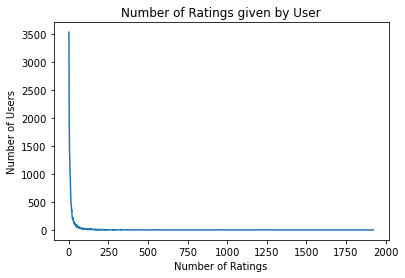

In [12]:
#Ex2.1--b-Plot the (number of users, number of ratings) rank-frequency distribution

df_plot_noOfRatings_noOfUsers = userLibraryExplode.groupBy("user_hash_id").count().withColumnRenamed("count","no_of_ratings").select("no_of_ratings").groupBy("no_of_ratings").count().withColumnRenamed("count","no_of_users").sort("no_of_ratings").toPandas()
plt.plot(df_plot_noOfRatings_noOfUsers.no_of_ratings,df_plot_noOfRatings_noOfUsers.no_of_users)
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.title('Number of Ratings given by User')

In [ ]:
#Ex2.1--c-Plot the (number of items, number of ratings) rank-frequency distribution

df_plot_noOfItems_noOfRatings = userLibraryExplode.groupBy("paper_id").count().withColumnRenamed("count","no_of_items").select("no_of_items").groupBy("no_of_items").count().withColumnRenamed("count","no_of_ratings").sort("no_of_ratings").toPandas()
plt.plot(df_plot_noOfItems_noOfRatings.no_of_ratings,df_plot_noOfItems_noOfRatings.no_of_items)
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Items')
plt.title('Number of Ratings each Paper Gets')



The Rank frequency distribution graph of Number of Ratings V/S Number of Items does form a Power Law with a long tail on the right side and displayed above. It clearly indicates that relative change in one quantity(Number of Ratings) results in a proportional relative change in the other quantity(Number of Items)

In [18]:
#Ex2.2-- Generating Ratings matrix

#Generating unique integer id for each user_hash_id
df_unique_int_user_id = df_userLibrary.withColumn("unique_int_user_id",row_number().over(Window.orderBy("user_hash_id")))

#Find List of distinct paper id's in user library
list_of_unique_paper_id = userLibraryExplode.select("paper_id").distinct().toPandas()
list_of_unique_paper_id = list(list_of_unique_paper_id["paper_id"])
no_unique_paperid = len(list_of_unique_paper_id)

##Preparing Data for generaton of Rating Matrix
#Function to select q random elements for each user
def deleteRandomElementsFromList(list_of_elements,no_of_elements_to_be_deleted):
    list_of_elements_to_be_deleted = rand.sample(list_of_elements,no_of_elements_to_be_deleted)
    deltaList = np.setdiff1d(list_of_elements,list_of_elements_to_be_deleted,assume_unique=True).tolist()
    return list(deltaList)
    
def findDeltaUserLibrary(x):
    no_of_rated_elements = len(x)
    no_of_elements_to_be_deleted = no_unique_paperid - 2*no_of_rated_elements
    unrated_papers_deltaList = np.setdiff1d(list_of_unique_paper_id,list(x),assume_unique=True).tolist()
    if len(unrated_papers_deltaList)>no_of_rated_elements:
        unrated_papers_deltaList = deleteRandomElementsFromList(unrated_papers_deltaList,no_of_elements_to_be_deleted)
    return list(unrated_papers_deltaList)

udf_findDeltaUserLibrary = udf(findDeltaUserLibrary, ArrayType(StringType()))

#dataframe for rated papers
ratings_matrix_with_ratedpapers = df_unique_int_user_id.select(df_unique_int_user_id.user_hash_id,df_unique_int_user_id.unique_int_user_id,
                                  explode(df_unique_int_user_id.user_library).alias("paper_id"),lit(1).alias("rating"))

#dataframe for unrated papers
ratings_matrix_with_unratedpapers = df_unique_int_user_id.select(df_unique_int_user_id.user_hash_id,df_unique_int_user_id.unique_int_user_id,
                                  explode(udf_findDeltaUserLibrary(df_unique_int_user_id.user_library)).alias("paper_id"),lit(0).alias("rating"))

#combining dataframes of rated and unrated papers
df_user_rating_matrix = ratings_matrix_with_ratedpapers.union(ratings_matrix_with_unratedpapers)
df_user_rating_matrix = df_user_rating_matrix.withColumn("paper_id",col("paper_id").cast(IntegerType()))
df_final_user_rating_matrix = df_user_rating_matrix.selectExpr("unique_int_user_id","paper_id","rating")

In [23]:
# The output of rating matrix
df_user_rating_matrix.show()

+--------------------+------------------+--------+------+
|        user_hash_id|unique_int_user_id|paper_id|rating|
+--------------------+------------------+--------+------+
|0002647bf4e8cfbb8...|                 1| 4235855|     1|
|00095808cdc611fb5...|                 2| 4252064|     1|
|00095808cdc611fb5...|                 2| 3859047|     1|
|00095808cdc611fb5...|                 2| 3226232|     1|
|00095808cdc611fb5...|                 2| 9452433|     1|
|00095808cdc611fb5...|                 2| 1325487|     1|
|000a87940e47aef8c...|                 3| 1129224|     1|
|000a87940e47aef8c...|                 3| 1290815|     1|
|000a87940e47aef8c...|                 3|   90557|     1|
|000a87940e47aef8c...|                 3|   77265|     1|
|000ac87bf9c1623ee...|                 4| 1203293|     1|
|000ac87bf9c1623ee...|                 4| 1228522|     1|
|000ac87bf9c1623ee...|                 4| 1203207|     1|
|000e5a48701b81078...|                 5|  580009|     1|
|000e5a48701b8

In [51]:
#Ex2.3,2.4

# Create ALS Model
user_paper_als_model = ALS(
         implicitPrefs = False,
         maxIter = 2,
         userCol="unique_int_user_id", 
         itemCol="paper_id",
         ratingCol="rating", 
         nonnegative = True, 
         coldStartStrategy="drop")

In [52]:
#Ex2.3,2.4

#Distributing the rating matrix data into 2 sets: training data(70%) and test data(30%)
(training_data, test_data) = df_final_user_rating_matrix.randomSplit([0.7, 0.3])

#Build the recommendation model using ALS on the training data: train the model using te training data
recommendation_model = user_paper_als_model.fit(training_data)

#Generate top 10 recommendations for all users and display
top_10_recommend_for_each_user = recommendation_model.recommendForAllUsers(10)

top_10_recommend_for_each_user = top_10_recommend_for_each_user.withColumn("recommended_papers", explode("recommendations")).select(
    'unique_int_user_id', col("recommended_papers.paper_id"), col("recommended_papers.rating"))

top_10_recommend_for_each_user = top_10_recommend_for_each_user.join(df_unique_int_user_id,top_10_recommend_for_each_user.unique_int_user_id == df_unique_int_user_id.unique_int_user_id,how="inner").select(
    df_unique_int_user_id.user_hash_id,top_10_recommend_for_each_user.unique_int_user_id,top_10_recommend_for_each_user.paper_id,top_10_recommend_for_each_user.rating)


In [70]:
#Ex2.3,2.4

#Displaying the top 10 recommendation for all users
top_10_recommend_for_each_user.show()

+--------------------+------------------+--------+----------+
|        user_hash_id|unique_int_user_id|paper_id|    rating|
+--------------------+------------------+--------+----------+
|016cbe6d6b9fb520f...|               148| 5308536| 1.0270573|
|016cbe6d6b9fb520f...|               148| 5840180| 1.0228165|
|016cbe6d6b9fb520f...|               148| 7943345| 0.9940475|
|016cbe6d6b9fb520f...|               148| 1386892|0.98722875|
|016cbe6d6b9fb520f...|               148|  381409| 0.9745653|
|016cbe6d6b9fb520f...|               148| 4235166| 0.9718689|
|016cbe6d6b9fb520f...|               148| 5930898|0.95211613|
|016cbe6d6b9fb520f...|               148| 7424783| 0.9461434|
|016cbe6d6b9fb520f...|               148| 2782279|0.94550604|
|016cbe6d6b9fb520f...|               148| 6656685|0.94221926|
|045662ed61d0a73cb...|               463| 2924195| 1.1467229|
|045662ed61d0a73cb...|               463| 3910275| 1.1441437|
|045662ed61d0a73cb...|               463| 2804619| 1.1123625|
|045662e

In [69]:
#Ex2.3,2.4

#Dispalying the top 10 recommendations for user with user hash id = 1eac022a97d683eace8815545ce3153f
top_10_recommend_for_each_user.filter("user_hash_id = '1eac022a97d683eace8815545ce3153f'").show()

+--------------------+------------------+--------+----------+
|        user_hash_id|unique_int_user_id|paper_id|    rating|
+--------------------+------------------+--------+----------+
|1eac022a97d683eac...|              3347| 6656685| 1.0605303|
|1eac022a97d683eac...|              3347| 1902953| 1.0243104|
|1eac022a97d683eac...|              3347| 4235166| 1.0191036|
|1eac022a97d683eac...|              3347| 1286298| 1.0186714|
|1eac022a97d683eac...|              3347| 2566574|  1.004444|
|1eac022a97d683eac...|              3347| 5280065| 1.0035944|
|1eac022a97d683eac...|              3347|  392801|  0.997721|
|1eac022a97d683eac...|              3347| 6498712| 0.9974292|
|1eac022a97d683eac...|              3347| 3173937|0.99642354|
|1eac022a97d683eac...|              3347| 8148888|   0.99544|
+--------------------+------------------+--------+----------+



In [ ]:
#Ex2.3,2.4

#Computng the RMSE value over the rating test data for above ALS Model

predictions = recommendation_model.transform(test_data)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error over the Test set = " + str(rmse))

In [ ]:
#Ex2.5

#a,b
new_user_paper_als_model = ALS(
         implicitPrefs = False,
         userCol="unique_int_user_id", 
         itemCol="paper_id",
         ratingCol="rating", 
         nonnegative = True, 
         coldStartStrategy="drop")


# Add hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder().addGrid(new_user_paper_als_model.rank, [10, 25, 50]).build()

#RMSE Evaluator
new_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")

# Build cross validation using CrossValidator
cv = CrossValidator(estimator=new_user_paper_als_model, estimatorParamMaps=param_grid, evaluator=new_evaluator, numFolds=5)

#Build the recommendation model using CV-ALS on the training data: train the model using te training data
new_recommendation_model = cv.fit(training_data)

#Extracting best model 
best_model = new_recommendation_model.bestModel

# View the predictions
test_predictions = best_model.transform(test_data)
new_model_rmse = evaluator.evaluate(test_predictions)


In [ ]:
print("Root-mean-square error over the Test set for Best Model = " + str(new_model_rmse))
print("Best Model Rank:", best_model._java_obj.parent().getRank())
print("Best Model MaxIter:", best_model._java_obj.parent().getMaxIter())